Add google disk

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Allow google colab to read h5 files

In [ ]:
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

Install the kaggle to system

In [ ]:
!pip install -q kaggle

Upload the kaggle.json

In [ ]:
from google.colab import files
files.upload()

Create the necessary folder path

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

Download the dataset from kaggle with API

In [ ]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content/gdrive/My\ Drive/pneumonia

Unzip all files

In [ ]:
import os
os.chdir('gdrive/My Drive/pneumonia')
!unzip -q chest-xray-pneumonia.zip 

To make sure Colab uses GPU you can run

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Make sure that the current GPU memory utilization is 0

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=8bbb5d693511a2a48f235016d6808b4548ecae822f1cb066201707f37a18c54e
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 26.3 GB  | Proc size: 159.1 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


If Util not 0% use kill

In [ ]:
!kill -9 -1

Import libraries

In [47]:
import numpy as np
import keras
from keras import applications, Sequential, Model, optimizers, models
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, History
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from tqdm import tqdm
import os
import h5py
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Variables with train and test directories. 
Some constant variables.

In [2]:
trainInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/train/"
testInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/test/"
validationInput = "/content/gdrive/My Drive/pneumonia/chest_xray/chest_xray/val/"
size = 199
epochs = 3
fileName = "/content/gdrive/My Drive/pneumonia/images.h5"
modelsDir = "/content/gdrive/My Drive/pneumonia/model1/"

In [ ]:
# keras.utils.normalize
def extractData(directory):
    labels = []
    images = []

    for nextDirectory in os.listdir(directory):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = directory + nextDirectory
            if not currentDirectory.startswith("."):
                for files in tqdm(os.listdir(currentDirectory)):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = Image.open(imagePath)
                        img = img.resize((size, size)).convert("RGB")
                        data = np.array(img.getdata())
                        img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
                        images.append(img)
                        labels.append(label)

    labels = np.asarray(labels)

    if directory is trainInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesTrain", data=images)
        out.create_dataset("labelsTrain", data=labels)
        out.close()
    elif directory is testInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesTest", data=images)
        out.create_dataset("labelsTest", data=labels)
        out.close()
    elif directory is validationInput:
        out = h5py.File(fileName, "a")
        out.create_dataset("imagesValidation", data=images)
        out.create_dataset("labelsValidation", data=labels)
        out.close()
    else:
        pass

In [ ]:
extractData(trainInput)
extractData(testInput)
extractData(validationInput)

100%|██████████| 9/9 [00:00<00:00, 25.17it/s]


Get the images and labels

In [3]:
x = h5py.File(fileName, "r")["imagesTrain"][:]
print(x.shape)

(5216, 199, 199, 3)


In [4]:
dset = h5py.File(fileName, "r")
labelsTrain, imagesTrain, labelsTest, imagesTest, labelsValidation, imagesValidation = dset["labelsTrain"][:], dset["imagesTrain"][:], dset["labelsTest"][:], dset["imagesTest"][:], dset["labelsValidation"][:], dset["imagesValidation"][:]

Reshape if fit_generator dont work

In [5]:
labelsTrain = to_categorical(labelsTrain, 2)
labelsTest = to_categorical(labelsTest, 2)
labelsValidation = to_categorical(labelsValidation, 2)
print("Train:", imagesTrain.shape, "Test:", imagesTest.shape, "Validation:", imagesValidation.shape)
print("Train:", labelsTrain.shape, "Test:", labelsTest.shape, "Validation:", labelsValidation.shape)

Train: (5216, 199, 199, 3) Test: (624, 199, 199, 3) Validation: (16, 199, 199, 3)
Train: (5216, 2) Test: (624, 2) Validation: (16, 2)


Add an model, the weights can be none or imagenet. Imagenet is pre-trained on ImageNet.     
include_top is set False in order to exclude the last three layers (including the final softmax layer with 200 classes of output)

This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.
Reduce learning rate when a metric has stopped improving.

Flatten() layer to flatten the tensor output. Dense is 2D layer which support the specification of their input shape. relu and softmax are different activations which used with layers, either can be used by activation layers. Activations: https://keras.io/activations/. Optimizers: https://keras.io/optimizers/. Losses: https://keras.io/losses/. Metrics: https://keras.io/metrics/. Compilation: https://keras.io/getting-started/sequential-model-guide/.

Measure time and creation of fit_generator: https://keras.io/models/model/#fit_generator , https://keras.io/models/model/#fit

Save the model

In [6]:
reduceLearningRate = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.001, verbose=1)
# reduceLearningRate = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1) 
earlyStop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
callbacks = [reduceLearningRate, earlyStop]

In [7]:
datagen = ImageDataGenerator(
    zoom_range=0.1,
    height_shift_range=0.1,
    width_shift_range=0.1,
    rotation_range=10
)

In [8]:
def trainModel(model, name):
  global history
  pattern = model(weights="imagenet", include_top=False, input_shape=(size, size, 3))

  addModel = Sequential()

  addModel.add(Flatten(input_shape=pattern.output_shape[1:]))
  # addModel.add(Dense(512, activation="relu"))
  # addModel.add(Dropout(0.1))
  addModel.add(Dense(256, activation="relu"))
  addModel.add(Dropout(0.2))
  addModel.add(Dense(512, activation="relu"))
  addModel.add(Dropout(0.4))
  addModel.add(Dense(2, activation="softmax"))

  md = Model(inputs=pattern.input, outputs=addModel(pattern.output))
  md.compile(loss="categorical_crossentropy", 
                  optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9), 
                  metrics=["accuracy"])
  
  history = md.fit_generator(datagen.flow(imagesTrain, labelsTrain, batch_size=32),
                   validation_data=datagen.flow(imagesTest, labelsTest),
                   callbacks=callbacks, epochs=epochs, verbose=1)
  
  md.save(modelsDir + name + ".h5")

In [9]:
trainModel(applications.InceptionV3, "InceptionV3")
# trainModel(applications.Xception, "Xception")
# trainModel(applications.DenseNet201, "DenseNet201")
# trainModel(applications.InceptionResNetV2, "InceptionResNetV2")
# trainModel(applications.MobileNetV2, "MobileNetV2")
# trainModel(applications.VGG16, "VGG16")
# trainModel(applications.ResNet152V2, "ResNet152V2")

Epoch 1/3
163/163 [==============================] - 76s 464ms/step - loss: 0.2619 - accuracy: 0.9089 - val_loss: 0.3256 - val_accuracy: 0.8734
Epoch 2/3
163/163 [==============================] - 49s 302ms/step - loss: 0.0999 - accuracy: 0.9630 - val_loss: 0.1009 - val_accuracy: 0.9215
Epoch 3/3
163/163 [==============================] - 50s 304ms/step - loss: 0.0751 - accuracy: 0.9726 - val_loss: 0.0340 - val_accuracy: 0.9215


# InceptionV3 results

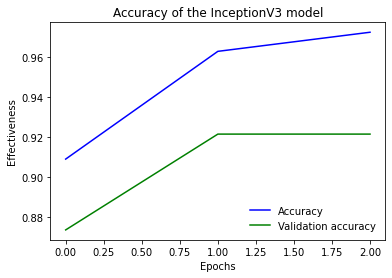

In [10]:
plt.plot(history.history["accuracy"], color="b", label="Accuracy")
plt.plot(history.history["val_accuracy"], color="g", label="Validation accuracy")
plt.legend(loc="lower right", frameon=False)
plt.title("Accuracy of the InceptionV3 model")
plt.xlabel("Epochs")
plt.ylabel("Effectiveness")
plt.show()

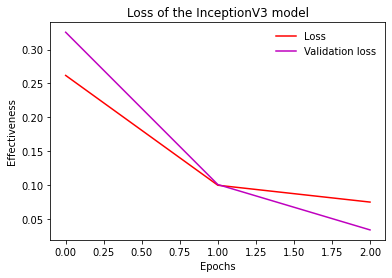

In [11]:
plt.plot(history.history["loss"], color="r", label="Loss")
plt.plot(history.history["val_loss"], color="m", label="Validation loss")
plt.legend(loc="upper right", frameon=False)
plt.title("Loss of the InceptionV3 model")
plt.xlabel("Epochs")
plt.ylabel("Effectiveness")
plt.show()

Load model and prediction

In [56]:
def prepareTestImages(dir_test_image):

    labels = []
    images = []

    for nextDirectory in os.listdir(dir_test_image):
        if not nextDirectory.startswith("."):
            if nextDirectory in "NORMAL":
                label = 0
            elif nextDirectory in "PNEUMONIA":
                label = 1
            else:
                label = 2

            currentDirectory = dir_test_image + nextDirectory
            if not currentDirectory.startswith("."):
                for files in os.listdir(currentDirectory):
                    if files.endswith('.jpg') or files.endswith('.jpeg'):
                        imagePath = currentDirectory + "/" + files
                        img = Image.open(imagePath)
                        img = img.resize((size, size)).convert("RGB")
                        data = np.array(img.getdata())
                        img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
                        images.append(img)
                        labels.append(label)

    labels = np.asarray(labels)

    out = h5py.File("/content/gdrive/My Drive/pneumonia/imagesTest.h5", "a")
    out.create_dataset("imagesTest", data=images)
    out.create_dataset("labelsTest", data=labels)
    out.close()

In [57]:
prepareTestImages("/content/gdrive/My Drive/pneumonia/test/")

In [58]:
dset = h5py.File("/content/gdrive/My Drive/pneumonia/imagesTest.h5", "r")
imagesTmp = dset["imagesTest"][:]
labelsTmp = dset["labelsTest"][:]

In [67]:
def modelsTest(dir_models):

  models_stat = []
  num_mod = 0

  for file_model in os.listdir(dir_models):
    num_mod += 1

    dir_model = dir_models + "/" + file_model
    name = file_model[:-3]
    model_stat = [name]
    print(name)
    model = models.load_model(dir_model)
    predictions = model.predict(imagesTmp[:])
    # print(predictions)
    accuracy = 0
    for i in range(len(predictions)):
      # print("pred", labelsTmp[i], format(predictions[i][0], ".2f"), format(predictions[i][1], ".2f"))
      if labelsTmp[i] == np.argmax(predictions[i]):
        accuracy += 1
        # print(format(predictions[i][0], ".2f"))
    print("Accuracy of predictions is: ", str(accuracy/len(predictions)*100) + "%")
  #     predictions = predictions.reshape(1, -1)[0]

  #     accuracy_array = []

  #     x = -1
  #     for i in range(0, len(predictions), 2):
  #         x += 1  
  #         if predictions[i] > predictions[i + 1]:
  #             if labels[x] == 0:
  #                accuracy_array.append(predictions[i])
  #                average_accuracy[x] += predictions[i]
  #             else: 
  #                accuracy_array.append(predictions[i + 1])  
  #                average_accuracy[x] += predictions[i + 1]

  #         if predictions[i] < predictions[i + 1]:
  #            if labels[x] == 1:
  #              accuracy_array.append(predictions[i + 1])
  #              average_accuracy[x] += predictions[i + 1]
  #            else: 
  #               accuracy_array.append(predictions[i])
  #               average_accuracy[x] += predictions[i]

  #     model_stat.append(np.sum(accuracy_array) / len(accuracy_array) * 100)
  #     models_stat.append(model_stat)
  #     print(model_stat)
  # for i in range(len(average_accuracy)):
  #     average_accuracy[i] = average_accuracy[i] / num_mod
  # models_stat.append(["Average", np.sum(average_accuracy) / len(average_accuracy) * 100])
  # print(["Average", np.sum(average_accuracy) / len(average_accuracy) * 100])

  # x_data = []
  # y_data = []
  # for i in range(len(models_stat)): 
  #     x_data.append(models_stat[i][0])
  #     y_data.append(models_stat[i][1])
  # _, ax = plt.subplots()
  # ax.bar(x_data, y_data, color = '#539caf', align = 'center')
  # ax.set_ylabel("Accuracy")
  # ax.set_xlabel("Models") 

In [68]:
modelsTest(modelsDir)

InceptionV3
Accuracy of predictions is:  93.42948717948718% 583


In [21]:
def global_predict(dir_models, dir_image):

    images_stat = []
    num_mod = 0

    name_image = []
    images = []

    for files in os.listdir(dir_image):
        if files.endswith(".jpg") or files.endswith(".jpeg"):
            imagePath = dir_image + files
            name_image.append(files)
            img = Image.open(imagePath)
            img = img.resize((size, size)).convert("RGB")
            data = np.array(img.getdata())
            img = 2 * (data.reshape((img.size[0], img.size[1], 3)).astype(np.float32) / 255) - 1
            images.append(img)

    out = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "a")
    out.create_dataset("imagesTmp", data=images)
    out.close()

    dset = h5py.File("/content/gdrive/My Drive/pneumonia/tmptest.h5", "r")
    imagesTmp = dset["imagesTmp"][:]
    os.remove("/content/gdrive/My Drive/pneumonia/tmptest.h5")

    for file_model in os.listdir(dir_models):
      if not file_model.startswith("."):
        print("==================================================\nCurrent model is: ", file_model)
        num_mod += 1
        dir_model = dir_models + "/" + file_model
    
        model = models.load_model(dir_model)
        predictions = model.predict(imagesTmp)
        predictions = predictions.reshape(1, -1)[0]

        accuracy_array = []

        for i in range(0, len(predictions), 2):
            accuracy_array.append(predictions[i + 1])
        images_stat.append(accuracy_array)
        print(accuracy_array)
    result = []    

    for i in range(len(name_image)):
        sum_ac = 0
        for j in range(num_mod):
            sum_ac += images_stat[j][i]  
        result.append([name_image[i], sum_ac / num_mod * 100])
    print(result)

In [22]:
global_predict(modelsDir, "/content/gdrive/My Drive/pneumonia/predict/")

Current model is:  DenseNet201.h5
[0.8051578, 0.31375858, 0.9218358, 0.2144099, 0.2797077, 0.9933089, 0.9997603, 0.99996066, 0.9999448, 0.9999738, 0.99963653]
Current model is:  VGG16.h5
[0.8669566, 0.15812396, 0.3225181, 0.46605927, 0.09625931, 0.9991066, 0.9999708, 0.99998987, 0.9999335, 0.9999831, 0.99993014]
Current model is:  MobileNetV2.h5
[0.18382469, 0.07634465, 0.25555867, 0.22616726, 0.03265058, 0.99678373, 0.99986184, 0.9999821, 0.9998324, 0.99991584, 0.9998671]
Current model is:  InceptionResNetV2.h5
[0.313137, 0.76187766, 0.6093225, 0.49602044, 0.2831848, 0.99933773, 0.9999341, 0.9999678, 0.99905556, 0.99993634, 0.99679935]
Current model is:  ResNet152V2.h5
[0.5787341, 0.069889344, 0.5062051, 0.38205102, 0.957041, 0.999995, 0.9999918, 1.0, 0.99999917, 0.999997, 0.99986935]
Current model is:  Xception.h5
[0.9838251, 0.9907239, 0.66596276, 0.89881146, 0.973041, 0.9534417, 0.9999893, 0.9987716, 0.9991842, 0.9950493, 0.9950193]
Current model is:  .ipynb_checkpoints


OSError: ignored